In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import torchvision.models as models
import os
import random


In [10]:
os.chdir("/kaggle/input")
os.listdir()

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


In [11]:
class ImageRatingDataset(Dataset):
    
    def __init__(self, dataframe, transform=None, augment=False, phase=''):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])
        self.augment = augment
        self.phase=phase

        # Define augmentations
        self.augmentation = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),  # small rotations
            transforms.RandomResizedCrop(size=(384, 512), scale=(0.9, 1.0), ratio=(1.25, 1.35)),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),  # light changes
        ])


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'filename']
        rating = self.dataframe.loc[idx, 'MOS']
        
        if self.phase == 'train':
            image = Image.open("/kaggle/input/raise-final-dataset-paper/dataset/images/train_images/" + img_path).convert('RGB')
        elif self.phase == 'test':
            image = Image.open("/kaggle/input/raise-final-dataset-paper/dataset/images/test_images/" + img_path).convert('RGB')

        if self.augment == True:
            image = self.augmentation(image)
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(rating, dtype=torch.float32)


In [12]:
class ResNetRegressor(nn.Module):
    def __init__(self):
        super(ResNetRegressor, self).__init__()

        # Load pretrained ResNet18
        base_model = models.resnet18(pretrained=True)

        # Remove the final classification layer
        self.features = nn.Sequential(*list(base_model.children())[:-1])  # Excludes fc layer

        # Freeze base layers
        for param in self.features.parameters():
            param.requires_grad = False

        # Add a custom regression head
        self.regressor = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = self.features(x)             # Output shape: (batch_size, 512, 1, 1)
        x = x.view(x.size(0), -1)        # Flatten to (batch_size, 512)
        x = self.regressor(x)
        return x


In [21]:
def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.0001, λ=1):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()  # Mean squared error loss for regression
    train_losses = []
    val_losses = []
    srocc_scores = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Training loop
        for images, ratings in train_loader:
            images = images.to(device)
            ratings = ratings.to(device)

            optimizer.zero_grad()
            outputs = model(images).squeeze(1)  # Remove extra dimension
            loss = mse_loss(outputs, ratings) 
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation loop
        val_loss, srocc = validate_model(model, val_loader)
        val_losses.append(val_loss)
        srocc_scores.append(srocc)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, "
              f"Validation Loss: {val_loss:.4f}, SROCC: {srocc:.4f}")
    # Plot and save loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True)
    # plt.savefig('ResNet50_loss_plot.png')
    plt.show()


In [22]:
def validate_model(model, val_loader):
    model.eval()
    val_predictions = []
    val_ground_truth = []

    with torch.no_grad():
        for images, ratings in val_loader:
            images = images.to(device)
            ratings = ratings.to(device)

            outputs = model(images).squeeze(1)  # Remove extra dimension

            val_predictions.extend(outputs.cpu().numpy())
            val_ground_truth.extend(ratings.cpu().numpy())

    # Compute SROCC
    srocc, _ = spearmanr(val_predictions, val_ground_truth)

    # Compute mean squared error for validation loss
    val_loss = mean_squared_error(val_ground_truth, val_predictions)

    return val_loss, srocc


In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetRegressor().to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"Total number of trainable parameters: {num_params:,}")


Total number of trainable parameters: 230,145


In [25]:
train_df = pd.read_csv("/kaggle/input/raise-final-dataset-paper/dataset/ratings/train.csv")
test_df = pd.read_csv("/kaggle/input/raise-final-dataset-paper/dataset/ratings/test.csv")

val_df = train_df.iloc[-90:].copy()
train_df = train_df.iloc[:-90].copy()

print(train_df.shape, val_df.shape, test_df.shape)


(420, 2) (90, 2) (90, 2)


Epoch [1/75], Loss: 0.9834, Validation Loss: 0.9800, SROCC: 0.2550
Epoch [2/75], Loss: 0.9829, Validation Loss: 0.9669, SROCC: 0.3642
Epoch [3/75], Loss: 0.9383, Validation Loss: 0.9552, SROCC: 0.4236
Epoch [4/75], Loss: 0.9825, Validation Loss: 0.9439, SROCC: 0.4487
Epoch [5/75], Loss: 0.9102, Validation Loss: 0.9247, SROCC: 0.4781
Epoch [6/75], Loss: 0.9856, Validation Loss: 0.9043, SROCC: 0.5057
Epoch [7/75], Loss: 0.8739, Validation Loss: 0.8686, SROCC: 0.5334
Epoch [8/75], Loss: 0.9267, Validation Loss: 0.8399, SROCC: 0.5146
Epoch [9/75], Loss: 0.9930, Validation Loss: 0.7957, SROCC: 0.5391
Epoch [10/75], Loss: 0.7917, Validation Loss: 0.7635, SROCC: 0.5292
Epoch [11/75], Loss: 0.7758, Validation Loss: 0.7294, SROCC: 0.5416
Epoch [12/75], Loss: 0.7502, Validation Loss: 0.7102, SROCC: 0.5368
Epoch [13/75], Loss: 0.7293, Validation Loss: 0.7014, SROCC: 0.5381
Epoch [14/75], Loss: 0.9867, Validation Loss: 0.6794, SROCC: 0.5550
Epoch [15/75], Loss: 0.7777, Validation Loss: 0.6794, SRO

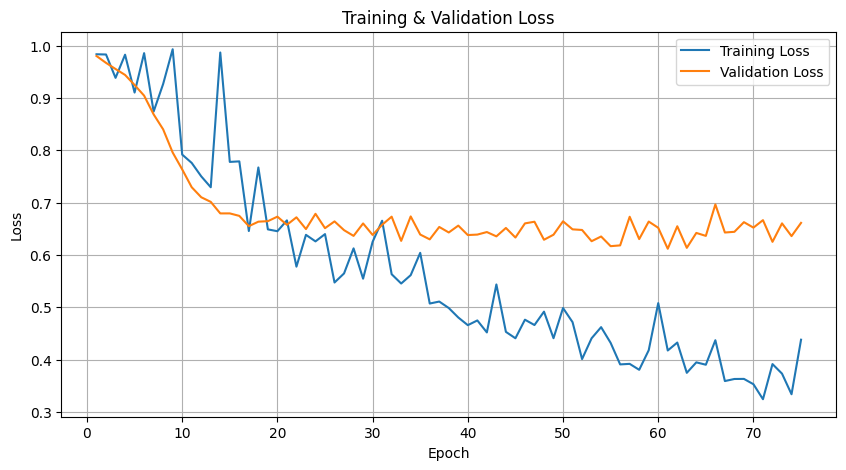

In [26]:
# Create dataset partitions
train_dataset = ImageRatingDataset(train_df, augment=True, phase='train')
val_dataset = ImageRatingDataset(val_df, phase='train')
test_dataset = ImageRatingDataset(test_df, phase='test')


# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# images, ratings = next(iter(train_loader))
# print(images)
# Start training
train_model(model, train_loader, val_loader, num_epochs=75)


In [27]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        # Detach and move to CPU; flatten the predictions.
        preds = outputs.cpu().numpy().flatten()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute Spearman's rank correlation coefficient (SROCC)
spearman_corr, _ = spearmanr(all_labels, all_preds)
pearson_corr, _ = pearsonr(all_labels, all_preds)

print(spearman_corr, pearson_corr)


0.6236078528213359 0.7043661


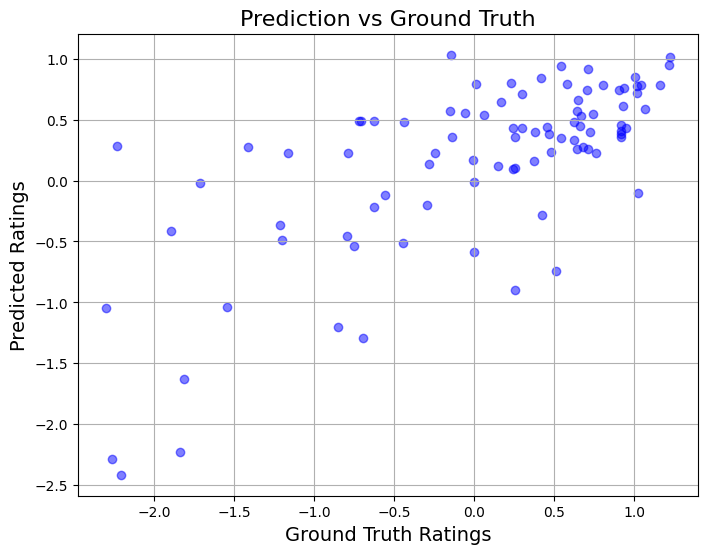

0.6236078528213359 0.7043661


In [28]:
predictions = []
ground_truths = []

# Iterate over the validation dataset
with torch.no_grad():
    for images, ratings in test_loader:
        images = images.to(device)  # Move to device (GPU or CPU)
        ratings = ratings.to(device)

        # Get predictions from the model
        predicted_ratings = model(images)

        # Append predicted and ground truth values to the lists
        predictions.extend(predicted_ratings.cpu().numpy())  # move to CPU and convert to numpy
        ground_truths.extend(ratings.cpu().numpy())  # move to CPU and convert to numpy

# Convert lists to numpy arrays
predictions = np.array(predictions).flatten()
ground_truths = np.array(ground_truths).flatten()

# # denormalize
# predictions = predictions*mos_std + mos_mean
# ground_truths = ground_truths*mos_std + mos_mean 

# Plot the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(ground_truths, predictions, alpha=0.5, c='blue')
plt.title('Prediction vs Ground Truth', fontsize=16)
plt.xlabel('Ground Truth Ratings', fontsize=14)
plt.ylabel('Predicted Ratings', fontsize=14)
plt.grid(True)
plt.show()

# Compute Spearman's rank correlation coefficient (SROCC)
spearman_corr, _ = spearmanr(ground_truths, predictions)
pearson_corr, _ = pearsonr(ground_truths, predictions)

print(spearman_corr, pearson_corr)


In [29]:
import torch, os

SAVE_DIR = "/kaggle/working"            # this is the only writable spot
WEIGHT_FILE = "resnet18_transf-learn-wts.pth"

os.makedirs(SAVE_DIR, exist_ok=True)
torch.save(model.state_dict(), f"{SAVE_DIR}/{WEIGHT_FILE}")
print("✔️  Weights written to", f"{SAVE_DIR}/{WEIGHT_FILE}")


✔️  Weights written to /kaggle/working/resnet18_transf-learn-wts.pth
